# 1. Introduction

Treves Li

UC Berkeley

2026-01-13

This notebook corrects drift from the Geophex GEM-2 Ski.

# 2. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.spatial import cKDTree
from sklearn.metrics import r2_score
from pathlib import Path

# Set root path
root_path = Path.cwd().parents[0]

# EMagPy libraries
from common_utils.gem_helpers import plot_raw_em, compute_em_drift, correct_em_drift

# 3. Import Start and End Calibrations

In [3]:
calib_start_fp  = root_path / "data" / "raw" / "20260115_em" / "1450-xg-15ja-129_gem.csv"
calib_end_fp    = root_path / "data" / "raw" / "20260115_em" / "1453-xg-15ja-180_gem.csv"

calib_start_em = pd.read_csv(calib_start_fp)
calib_end_em = pd.read_csv(calib_end_fp)

t_ref_ms = calib_start_em["Time[ms]"].mean()
t_end_ms = calib_end_em["Time[ms]"].mean()
dt_hr = (t_end_ms - t_ref_ms) / (3600 * 1000) # ms to hr

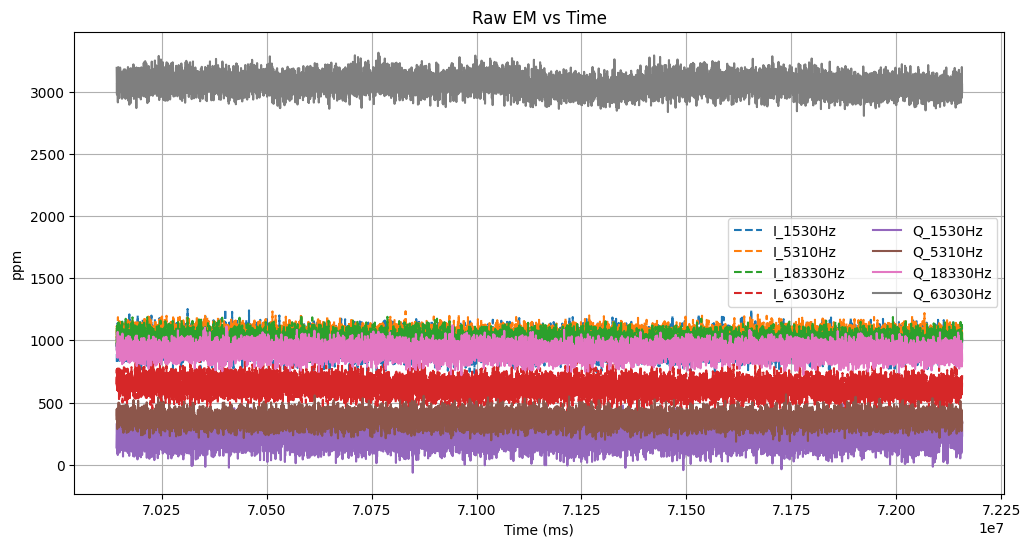

In [4]:
plot_raw_em(calib_start_em)

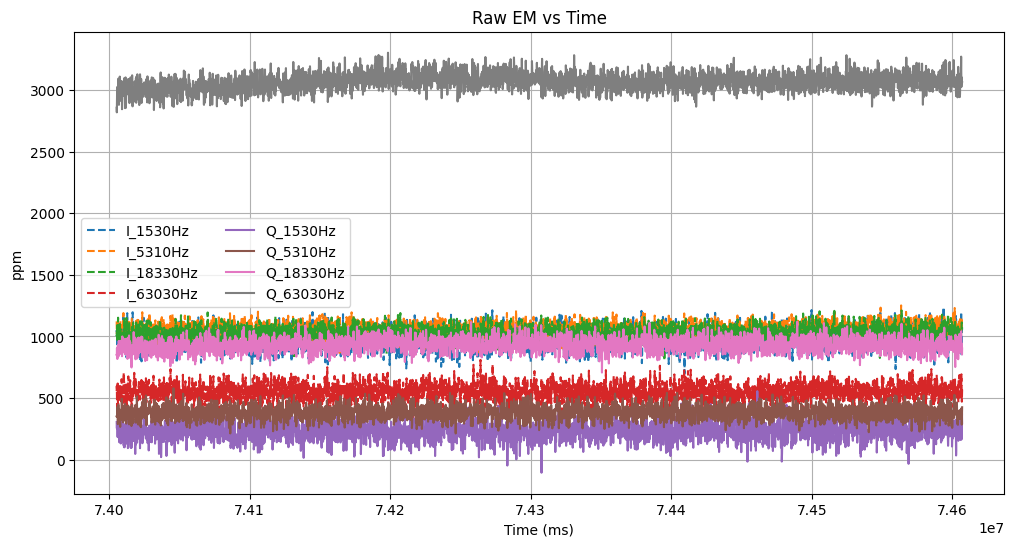

In [5]:
plot_raw_em(calib_end_em)

# 4. Compute Drift

In [6]:
drift_rate_ms = compute_em_drift(calib_start_em, calib_end_em)

In [7]:
drift_rate_hr = drift_rate_ms * 3600 * 1000 # per ms to per hr
print(
    f"Drift rate per hour over {dt_hr:.2f} hrs:\n\n"
    f"{drift_rate_hr}"
)

Drift rate per hour over 0.88 hrs:

I_1530Hz     11.260022
Q_1530Hz     15.016274
I_5310Hz     19.963654
Q_5310Hz     17.833454
I_18330Hz    30.801732
Q_18330Hz    20.193144
I_63030Hz   -84.672754
Q_63030Hz     7.686224
dtype: float64


Compute error between start and end calibrations.

In [8]:
# Select only I_ and Q_ columns
em_cols = [c for c in calib_start_em.columns if c.startswith(('I_', 'Q_'))]

# Compute mean signal at start
start_mean = calib_start_em[em_cols].mean()
end_mean = calib_end_em[em_cols].mean()

drift_error_pc = abs(((end_mean - start_mean) / start_mean)) * 100

print(
    f"Drift error % over {dt_hr:.2f} hrs:\n\n"
    f"{drift_error_pc}"
)

Drift error % over 0.88 hrs:

I_1530Hz      1.015725
Q_1530Hz      5.897412
I_5310Hz      1.689181
Q_5310Hz      4.266503
I_18330Hz     2.697578
Q_18330Hz     1.937873
I_63030Hz    11.865586
Q_63030Hz     0.220004
dtype: float64


# 5. Correct Drift

In [ ]:
input_file = root_path / "data" / "raw" / "20260115_em" / "1452-xg-15ja-144_gem.csv" # TODO

output_dir = root_path / 'data' / 'processed' / '20260115_em_processed' # TODO
output_dir.mkdir(parents=True, exist_ok=True)
output_name = re.sub(r'^(\d{4}).*', r'\1_drifted.csv', input_file.stem)
output_file = output_dir / output_name

# Import the file as df
df_to_correct = pd.read_csv(input_file)

# Apply drift correction and save
correct_em_drift(df_to_correct, drift_rate_ms, t_ref_ms, t_end_ms).to_csv(output_file, index=False)
print(f"Drift correction applied to {input_file.stem}.csv. \nFile saved to {output_file.stem}.csv.")

Drift correction applied to 1452-xg-15ja-144_gem.csv. 
File saved to 1452_drifted.csv.


# 6. Validate Drift Correction

## Start and End Calibration Comparison

In [12]:
# Check that a drift was actually applied (select some random EM survey)

pre_drifted_em = pd.read_csv(input_file)
post_drifted_em = pd.read_csv(output_file)

print(f"Pre drift correction mean: {pre_drifted_em['Q_63030Hz'].mean():.2f} ppm")
print(f"Post drift correction mean: {post_drifted_em['Q_63030Hz'].mean():.2f} ppm")

Pre drift correction mean: 7466.05 ppm
Post drift correction mean: 7460.35 ppm


We should expect that the calculated drift is zero after correction if `correct_em_drift` worked correctly.

In [13]:
post_drifted_calib_end = correct_em_drift(calib_end_em, drift_rate_ms, t_ref_ms, t_end_ms)

validation_drift_rate_ms = compute_em_drift(calib_start_em, post_drifted_calib_end)
print(validation_drift_rate_ms.map("{:.6f}".format))

I_1530Hz      0.000000
Q_1530Hz      0.000000
I_5310Hz      0.000000
Q_5310Hz      0.000000
I_18330Hz     0.000000
Q_18330Hz     0.000000
I_63030Hz    -0.000000
Q_63030Hz     0.000000
dtype: object


If all zeros, then we are good.

# 7. Free-Air Calibration of Q values (if required)

`start_mean` is the free-air zero reference. We need to subtract it from drift-corrected survey data, such that all anomalies are relative to the background.

$$ \text{calibrated signal} = \text{measured signal} − \text{free-air mean} $$

In [16]:
input_file_drifted = output_dir / '1452_drifted.csv' # TODO

# Read drift-corrected data
input_file_zeroed = pd.read_csv(input_file_drifted).copy()

# Build output filename safely
if re.match(r'^\d{4}_drifted$', input_file_drifted.stem):
    output_name_zeroed = f"{input_file_drifted.stem}_zeroed.csv"
else:
    m = re.match(r'^(\d{4})', input_file_drifted.stem)
    if not m:
        raise ValueError(f"Unexpected filename format: {input_file_drifted.stem}")
    output_name_zeroed = f"{m.group(1)}_zeroed.csv"
output_file_zeroed = output_dir / output_name_zeroed

# Apply free-air calibration
for col in em_cols:
    input_file_zeroed[col] = input_file_zeroed[col] - start_mean[col]

# Save zeroed data
input_file_zeroed.to_csv(output_file_zeroed, index=False)
print(
    f"Free-air calibration correction applied to {input_file_drifted.stem}.csv. \n"
    f"File saved to {output_file_zeroed.stem}.csv."
)

Free-air calibration correction applied to 1452_drifted.csv. 
File saved to 1452_drifted_zeroed.csv.


## Tie Lines

Do this step after processing the EM points in [`01_em_inversion_v2.ipynb`](01_em_inversion_v2.ipynb).

Import `*_drifted_processed.csv` files in QGIS (i.e., intermediate EM files pre-inversion).

Combine all main survey points (`data/processed/{date}_em_processed/{date}_combined_drifted_processed.csv`), and separately combine all tie line points (`data/processed/{date}_em_processed/{date}_tieline_drifted_processed.csv`).

In [11]:
# TODO: Update file paths
main_survey = root_path / 'data' / 'processed' / '20251006_em_processed' / '20251006_combined_drifted_processed.csv'
tie_lines = root_path / 'data' / 'processed' / '20251006_em_processed' / '20251006_tieline_drifted_processed.csv'

exclude_cols = {'time', 'layer', 'path'}

# Import data
main_survey_df = pd.read_csv(
    main_survey,
    usecols=lambda col: col not in exclude_cols
)
tie_lines_df = pd.read_csv(
    tie_lines,
    usecols=lambda col: col not in exclude_cols
)

For each point in `main_survey_df`, see if there's a point in `tie_lines_df` within a specified radius. (Let that radius be 0.25 m to start). If there are multiple matches, get the closest one.

We'll build some new data structure that allows us to compare `main_survey` points against their `tie_line` counterparts. The idea is that after drift correction, their values should be the same.

In [12]:
# Radius threshold (meters)
radius = 0.25

# Coords
main_coords = main_survey_df[['X', 'Y']].to_numpy()
tie_coords = tie_lines_df[['X', 'Y']].to_numpy()

# Build KDTree for fast spatial search
tree = cKDTree(tie_coords)

# Query nearest tie-line point, for each main_survey point
distances, indices = tree.query(main_coords, distance_upper_bound=radius)

# If no match, distance=inf and index=len(tie_coords)
valid_mask = np.isfinite(distances)

# Filter matches within radius
main_matched = main_survey_df.loc[valid_mask].reset_index(drop=True)
tie_matched = tie_lines_df.iloc[indices[valid_mask]].reset_index(drop=True)

# Combine into comparison DataFrame
calib_comparison_df = pd.concat(
    [main_matched.add_suffix('_main'),
     tie_matched.add_suffix('_tie'),
     pd.Series(distances[valid_mask], name='dist_m')],
    axis=1
)

print(f"Matched {len(calib_comparison_df)} sets of points within {radius} m")

Matched 15 sets of points within 0.25 m


In [13]:
def clean_channel_names(df):
    # Only rename columns that exist in df
    rename_map = {
        c: c.replace('HCP1.66f', '').replace('h1', 'Hz')
        for c in df.columns
        if 'HCP1.66f' in c
    }
    return df.rename(columns=rename_map)

main_survey_df      = clean_channel_names(main_survey_df)
tie_lines_df        = clean_channel_names(tie_lines_df)
calib_comparison_df = clean_channel_names(calib_comparison_df)

channel_cols = [c for c in main_survey_df.columns if c not in ['X', 'Y']]

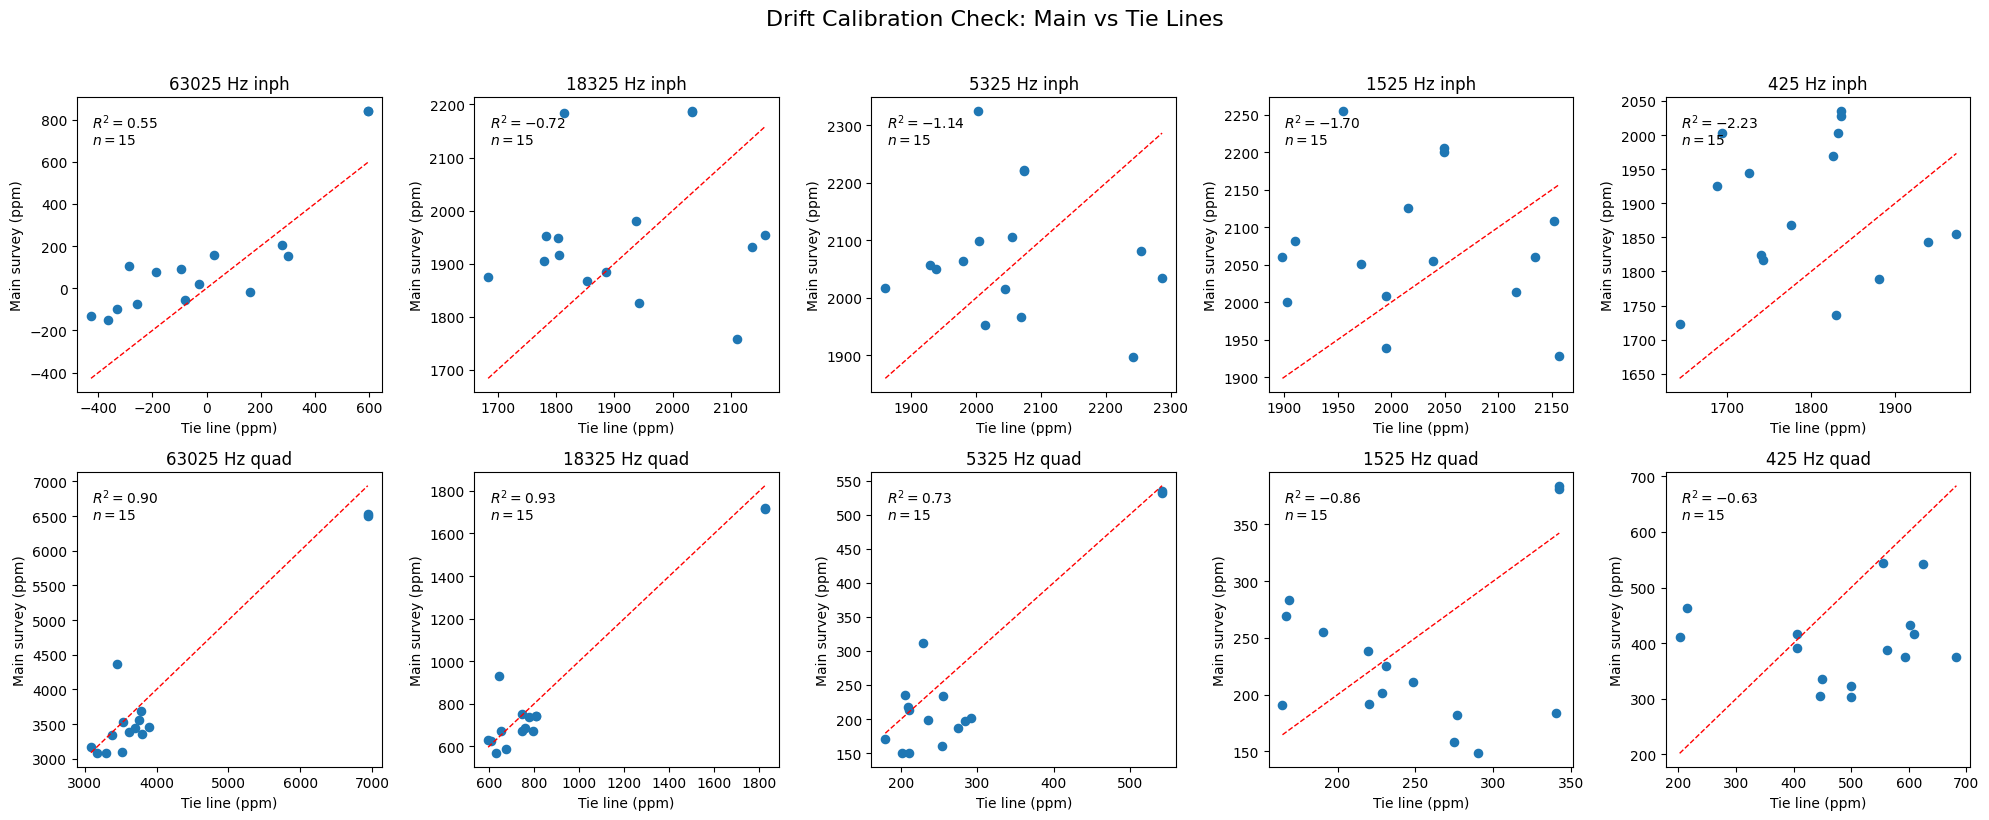

In [ ]:
# Sort channels by frequency
freqs = sorted(
    [float(c.split('Hz')[0]) for c in channel_cols if '_inph' in c],
    reverse=True
)

# Set up figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

# Loop through frequencies
for i, f in enumerate(freqs[:5]):  # Top 5 frequencies
    for j, typ in enumerate(['inph', 'quad']):
        ax = axes[j, i]
        ch = f"{int(f)}Hz_{typ}"

        x = calib_comparison_df[f"{ch}_tie"].to_numpy()
        y = calib_comparison_df[f"{ch}_main"].to_numpy()

        # Scatter plot with matplotlib
        ax.scatter(x, y, s=35)

        # 1:1 reference line
        minv, maxv = np.nanmin(x), np.nanmax(x)
        ax.plot([minv, maxv], [minv, maxv], 'r--', lw=1)

        # Compute stats
        mask = np.isfinite(x) & np.isfinite(y)
        if np.any(mask):
            r2 = r2_score(x[mask], y[mask])
            n = np.sum(mask)
        else:
            r2, n = np.nan, 0

        # Place R² and n inside plot (top-left corner)
        ax.text(
            0.05, 0.95,
            rf"$R^2 = {r2:.2f}$" + "\n" + f"$n={n}$",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=10
        )

        # Labels and title
        ax.set_title(f"{int(f)} Hz {typ}")
        ax.set_xlabel("Tie line (ppm)")
        ax.set_ylabel("Main survey (ppm)")

        # ax.grid()

# Add super title
fig.suptitle("Drift Calibration Check: Main Survey vs Tie Lines", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()